In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import seaborn as sns

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\Abhishek\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%run utils.py

In [3]:
# load train and test files
train, test = load_data()

Loading datasets
Setting Quote Number as index


In [4]:
# size of training and test set

print train.shape
print test.shape

(260753, 298)
(173836, 297)


In [5]:
# replace missing values with -1

train = train.fillna(-1)
test = test.fillna(-1)

In [6]:
# external script
%run scripts/helper.py
%run scripts/eval.py

In [31]:
# take a sample of the data
X, y = random_sample(train, 5000)
# X = train[train.columns.drop('QuoteConversion_Flag')]
# y = train['QuoteConversion_Flag']

In [32]:
# divide into training and test set
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [33]:
# shape of X_train and X_test
print X_train.shape, X_test.shape

(3500, 297) (1500, 297)


In [34]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

from scipy.stats import randint as sp_randint

In [35]:
%run features.py

## Extreme Gradient Boosting Model

In [36]:
import xgboost as xgb

In [37]:
ft = FeatureTransformer(train, test)
extreme_gb = xgb.XGBClassifier(n_estimators=700, max_depth=8, learning_rate=0.01, 
                               min_child_weight=50, subsample=0.9, colsample_bytree=0.8)

xgb_pipe = Pipeline([('ft', ft), ('xgb', extreme_gb)])

In [38]:
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ft', FeatureTransformer(test=None, train=None)), ('xgb', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=50, missing=None, n_estimators=700, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9))])

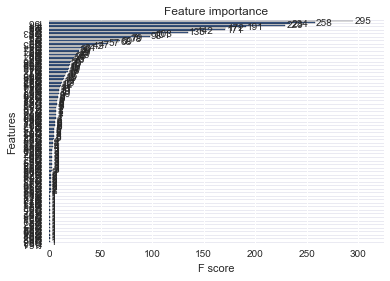

In [62]:
xgb.plot_importance(xgb_pipe.get_params()['xgb'], height=0.5)
plt.yticks(rotation=180);

In [44]:
predsTest = xgb_pipe.predict_proba(X_test)[:, 1]

In [45]:
print 'ROC AUC score on the test set %f ' %roc_auc_score(y_test, predsTest)

ROC AUC score on the test set 0.928799 


## Crossvalidation

In [30]:
mean, std = eval_models([xgb_pipe], X_train, y_train)
print 'Mean score %f and standard deviation %f ' %(mean, std)

score: 0.962489
combined score: 0.962489 
score: 0.954780
combined score: 0.954780 


C:\Users\Abhishek\Anaconda2\lib\site-packages\sklearn\cross_validation.py:758: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  "removed (assumed True) in 0.17", DeprecationWarning)


KeyboardInterrupt: 

## Accuracy on the unseen examples

In [ ]:
extreme_gb_test_preds = xgb_pipe.predict_proba(X_test)[:, 1]

print 'ROC AUC score on test examples is %f ' %(roc_auc_score(y_test, extreme_gb_test_preds))

## Ensembling

In [ ]:
mean, std = eval_models([pipeline_log, pipeline_extreme_gb], X_train, y_train)
print 'Mean score %f and standard deviation %f ' %(mean, std)

In [ ]:
ensemble_preds = 0.5 * predsTest + 0.5 * extreme_gb_test_preds

print 'ROC AUC score on test examples is %f ' %(roc_auc_score(y_test, ensemble_preds))

## Train on full training set

In [34]:
xgb_pipe.fit(X, y)

Pipeline(steps=[('ft', FeatureTransformer()), ('xgb', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=6, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9))])

In [55]:
test_preds_extreme_gb = xgb_pipe.predict_proba(test)[:, 1]

In [57]:
sixteenth_submission = pd.read_csv('./submissions/sixteenth_submission.csv')
twenty_third_submission = pd.read_csv('./submissions/twenty_third_submission.csv')

sixteenth_ranked = transform_for_ranked(sixteenth_submission.QuoteConversion_Flag, sixteenth_submission.index.values)
twenty_third_ranked = transform_for_ranked(twenty_third_submission.QuoteConversion_Flag, twenty_third_submission.index.values)

In [58]:
ensemble_ranks = ranked_averaging([sixteenth_ranked, twenty_third_ranked])

In [60]:
ensemble_preds = [k3 for k1, k2, k3 in ensemble_ranks]

## Create Kaggle submission file

In [61]:
# create submission file
submission = pd.read_csv('./data/sample_submission.csv')
submission['QuoteConversion_Flag'] = ensemble_preds
submission.to_csv('./submissions/twenty_fourth_submission.csv', index=False)